In [6]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import itertools
import scipy
import lfig
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from latex_figure import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

In [21]:
probe_dict = qmla.shared_functionality.probe_set_generation.plus_probes_dict(
    num_probes = 2,
    max_num_qubits = 8, 
)
probe = probe_dict[(0,1)]

In [159]:
def evolve_one_stage(
    ham_forward, 
    ham_backward, 
    probe,
    t
):
    operator = ham_forward - ham_backward
    unitary = scipy.linalg.expm(-1j*operator*t)
    
    evolved = np.dot(unitary, probe)
    return evolved

def evolve_two_stage(
    ham_forward, 
    ham_backward, 
    probe,
    t
):
    unitary_forward = scipy.linalg.expm(-1j*ham_forward*t)
    unitary_backward = scipy.linalg.expm(1j*ham_backward*t)
    
    evolved_first = np.dot(unitary_backward, probe)
    evolved = np.dot(unitary_backward, evolved_first)
    return evolved




In [143]:
def loschmidt_echo(
    ham_forward, 
    ham_backward, 
    probe,
    t
):
    H = ham_backward - ham_forward
    U = scipy.linalg.expm(1j*H*t)
    p1 = np.dot(U, probe)
    p2 = np.dot(probe.conj().T, p1)
    return np.abs(p2)**2

def loschmidt_echo_verbose(
    ham_forward, 
    ham_backward, 
    probe,
    t
):
    
    u1 = scipy.linalg.expm(-1j*ham_forward*t)
    u2 = scipy.linalg.expm(1j*ham_backward*t)
    
    p1 = np.dot(u1, probe)
    p2 = np.dot(u2, p1)
    lik = np.dot(probe.conj().T, p2)
    le = np.abs(lik)**2
    return le

In [190]:

true_model_params = {
    'pauliSet_1_x_d6' : 0.9, 
    'pauliSet_1_y_d6' : 0.15,
    'pauliSet_1_z_d6' : 0.5,    
    'pauliSet_2_x_d6' : 0.9, 
    'pauliSet_2_y_d6' : 0.15,
    'pauliSet_2_z_d6' : 0.5,    
    'pauliSet_3_y_d6' : 0.15,
    'pauliSet_4_z_d6' : 0.5,    
    'pauliSet_4_x_d6' : 0.9, 
    'pauliSet_5_y_d6' : 0.15,
    'pauliSet_6_z_d6' : 0.5, 
    'pauliSet_4J6_xJx_d6' : 0.9, 
    'pauliSet_2J5_yJy_d6' : 0.15,
    'pauliSet_1J4_zJz_d6' : 0.5,
    'pauliSet_2J3_xJx_d6' : 0.9, 
    'pauliSet_3J5_yJy_d6' : 0.15,
    'pauliSet_4J6_zJz_d6' : 0.5,
}
n_terms = len(true_model_params)
true_hamiltonian = None
for k in true_model_params: 
    if true_hamiltonian is None: 
        true_hamiltonian = true_model_params[k] * qmla.construct_models.compute(k)
    else:
        true_hamiltonian += true_model_params[k] * qmla.construct_models.compute(k)

param_scale_norms = []
for param_scalar in np.arange(0, 0.3, 0.025):
    for i in range(10):
        test_hamiltonian_params = {
            k : true_model_params[k]*np.random.uniform(
                1 - param_scalar, 1 + param_scalar) 
                for k in true_model_params
        } # same terms with slightly different params

        test_ham = None
        for k in test_hamiltonian_params: 
            if test_ham is None: 
                test_ham = test_hamiltonian_params[k] * qmla.construct_models.compute(k)
            else:
                test_ham += test_hamiltonian_params[k] * qmla.construct_models.compute(k)
        num_qubits = np.log2(np.shape(true_hamiltonian)[0])
        probe = probe_dict[(0,num_qubits)]
        frob_norm = np.linalg.norm(true_hamiltonian - test_ham)
        norm2 = np.linalg.norm(true_hamiltonian - test_ham, 2)

        param_scale_norms.append({
            "param_scalar" : param_scalar,
            "two_norm" : np.round(norm2, 3),
            "test_hamiltonian" : test_ham
        })
param_scale_df = pd.DataFrame(param_scale_norms)

In [191]:
hamiltonian_idx = param_scale_df[
    (0.24 < param_scale_df.two_norm)
    & ( param_scale_df.two_norm <= 0.26)
].index[0]

2-norm =  0.25185876912183713


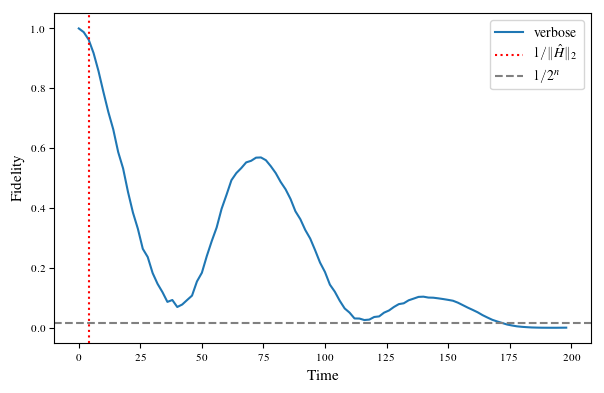

In [192]:
times = np.arange(0, 200, 2)
test_ham = param_scale_df.iloc[hamiltonian_idx].test_hamiltonian # has norm ~ 0.1

lecho = np.array([
    loschmidt_echo_verbose(
        ham_forward = true_hamiltonian, 
        ham_backward = test_ham, 
        probe = probe, 
        t = t
    ) for t in times
])

lf = lfig.LatexFigure(auto_label=False)
ax = lf.new_axis()

ax.plot(
    times, 
    lecho,
    label="verbose"
)
two_norm = np.linalg.norm(true_hamiltonian - test_ham, 2)
first_time_cutoff = 1 / two_norm
print("2-norm = ", two_norm)
ax.axvline(
    first_time_cutoff, 
    ls = ':', 
    c ='red', 
    label=r"$1 / \|\hat{H}\|_2$"
)

saturation_fidelity = 1 / 2**num_qubits
ax.axhline(saturation_fidelity, ls='--', color='grey', label=r"${1}/{2^n}$")

ax.set_ylabel("Fidelity")
ax.set_xlabel("Time")
ax.legend()


(0, 1)

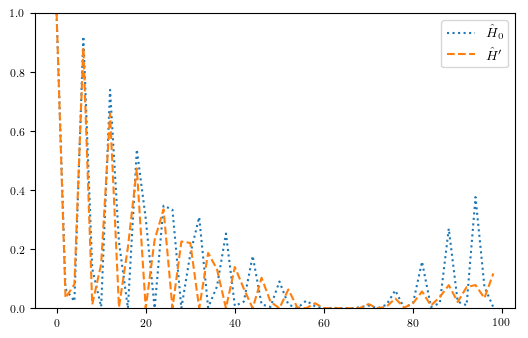

In [125]:
true_likelihoods = [
    qmla.shared_functionality.expectation_value_functions.default_expectation_value(
        ham = true_hamiltonian, 
        state = probe,
        t = t
    )
    for t in times
]
test_likelihoods = [
    qmla.shared_functionality.expectation_value_functions.default_expectation_value(
        ham = test_ham, 
        state = probe,
        t = t
    )
    for t in times
]


lf = LatexFigure()
ax = lf.new_axis()

ax.plot(
    times, 
    true_likelihoods,
    label=r'$\hat{H}_0$',
    ls=':'
)

ax.plot(
    times, 
    test_likelihoods,
    label=r'$\hat{H}^{\prime}$',
    ls = '--'
)

ax.legend()
ax.set_ylim(0,1)